Needed Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as ts
from  tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay,classification_report

Steps to download Kaggle datasets in Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"selmabouagina","key":"4d97b429624cbae81193f4cb58ff3b06"}'}

In [4]:
!ls -lha kaggle.json
!pip install -q kaggle


-rw-r--r-- 1 root root 69 Nov 23 08:41 kaggle.json


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
#!kaggle datasets list #list all available datasets

/content


In [6]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.76G/1.76G [00:21<00:00, 36.2MB/s]
100% 1.76G/1.76G [00:21<00:00, 86.4MB/s]


In [7]:
!unzip lung-and-colon-cancer-histopathological-images.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008

In [8]:
!ls  # Lists the contents of the current directory
!ls dataset/  # Adjust the path as necessary to explore the unzipped contents


gdrive	     lung-and-colon-cancer-histopathological-images.zip  sample_data
kaggle.json  lung_colon_image_set
ls: cannot access 'dataset/': No such file or directory


Loading Data

In [9]:
lung_colon_dir = "lung_colon_image_set/"
!ls {lung_colon_dir}


colon_image_sets  lung_image_sets


In [10]:
filepaths = []
labels = []
for root, dirs, files in os.walk(lung_colon_dir):
    for klass in dirs:
        if klass in ["lung_image_sets", "colon_image_sets"]:
            continue  # Skip the main classes, only consider subclasses
        classpath = os.path.join(root, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis=1)
df = data_df.reset_index(drop=True)  # Make a combined dataframe

print(df['labels'].value_counts())

lung_aca     5000
lung_n       5000
lung_scc     5000
colon_n      5000
colon_aca    5000
Name: labels, dtype: int64


In [11]:
sample_size=5000
sample_list=[]
group=df.groupby('labels')
for label in df['labels'].unique():
    label_group=group.get_group(label).sample(sample_size, replace=False, random_state=123, axis=0)
    sample_list.append(label_group)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))

25000


The distribution of images for different types of lung cancer

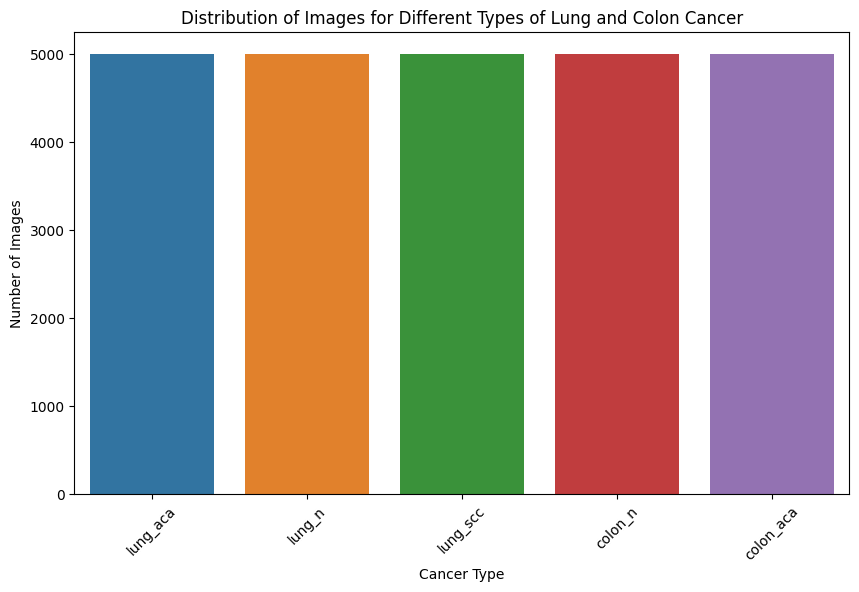

In [12]:
# Count the number of images per label in the sampled dataset
label_counts = df['labels'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Images for Different Types of Lung and Colon Cancer')
plt.xlabel('Cancer Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)  # Rotate the x labels if they are too long
plt.show()

In [13]:
def display_image_grid(images, labels, rows, cols):
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = axs.ravel()

    for i in range(rows*cols):
        img = Image.open(images[i])
        axs[i].imshow(img)
        axs[i].set_title(labels[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

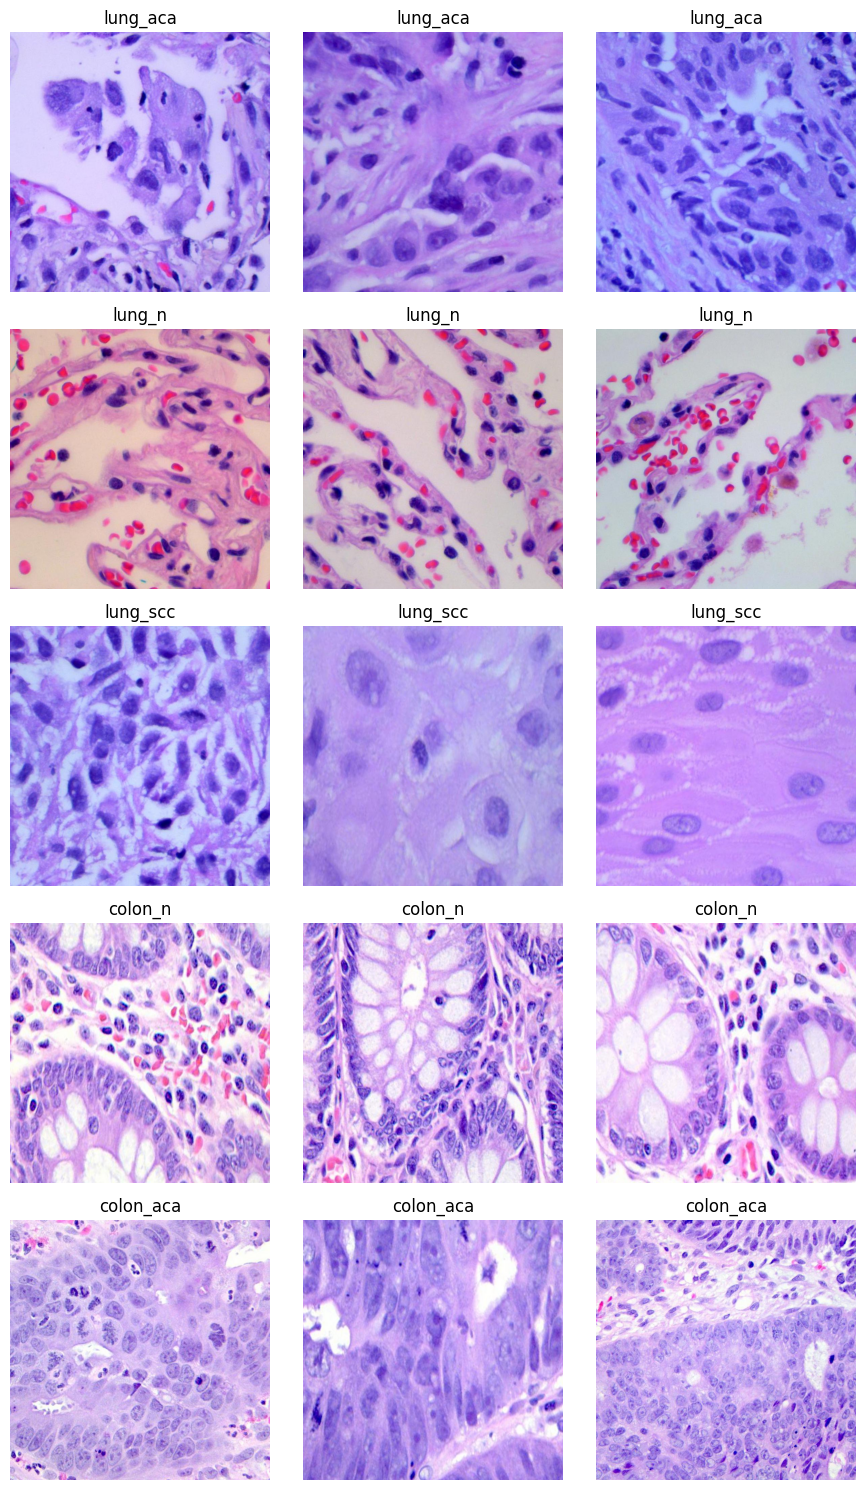

In [14]:
# Selecting a few images from each category
num_images_per_category = 3
selected_images = []
selected_labels = []

for label in df['labels'].unique():
    # Filter the dataframe for the current label
    label_df = df[df['labels'] == label]

    # Sample images
    sample_images = label_df['filepaths'].sample(num_images_per_category, random_state=123).tolist()
    selected_images.extend(sample_images)
    selected_labels.extend([label] * num_images_per_category)

# Display the images
display_image_grid(selected_images, selected_labels, rows=len(df['labels'].unique()), cols=num_images_per_category)

Data Augmentation

In [15]:
from keras.preprocessing.image import ImageDataGenerator

# For training data (with data augmentation)
train_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # assuming you're using 20% of the data for validation
)

# For validation data (without data augmentation, just rescaling)
validation_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# For test data (without data augmentation, just rescaling)
test_gen = ImageDataGenerator(rescale=1./255)


This code correctly splits the dataset into 80% training, 10% testing, and 10% validation sets

In [16]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), ' test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  20000  test_df length:  2500   valid_df length:  2500


In [17]:
batch_size=32
img_size=(224, 224)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


Setting callbacks

In [18]:
# Early stopping callback to stop training when no improvement in validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # To print messages when the callback takes an action
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Reduce learning rate when a metric has stopped improving
plateau = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.1,          # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=3,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # To print messages when the callback takes an action
    min_lr=0.00001       # The lower bound of the learning rate
)

First Model

In [ ]:
model_1 = keras.models.Sequential()

model_1.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model_1.add(keras.layers.Dropout(0.1))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.15))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Conv2D(128, 3, activation='relu'))
model_1.add(keras.layers.Dropout(0.2))
model_1.add(keras.layers.MaxPooling2D())

model_1.add(keras.layers.Flatten())
model_1.add(keras.layers.Dense(256, activation='relu'))
model_1.add(keras.layers.Dense(5, activation='softmax'))

model_1.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 dropout_9 (Dropout)         (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 dropout_10 (Dropout)        (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                

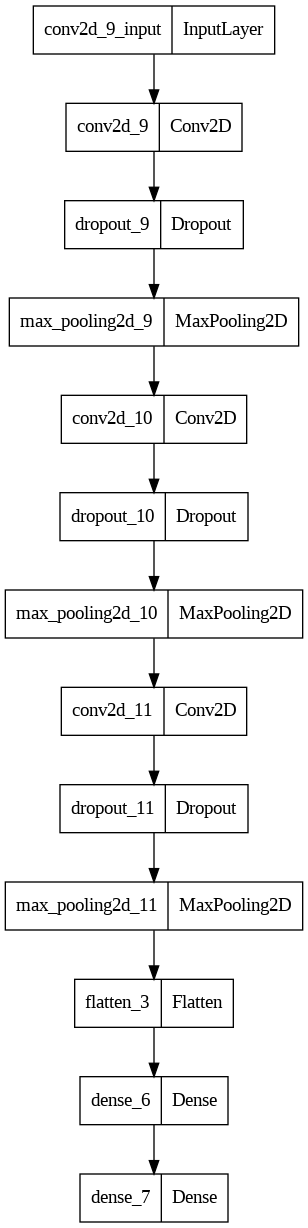

In [ ]:
keras.utils.plot_model(
    model_1,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
history = model_1.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=10,
    callbacks=[early_stopping, plateau],
)


Epoch 1/10
625/625 [==============================] - 3153s 5s/step - loss: 0.4470 - accuracy: 0.8352 - val_loss: 0.2090 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 3099s 5s/step - loss: 0.1541 - accuracy: 0.9402 - val_loss: 0.1624 - val_accuracy: 0.9436 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 3088s 5s/step - loss: 0.0886 - accuracy: 0.9680 - val_loss: 0.1163 - val_accuracy: 0.9592 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 3106s 5s/step - loss: 0.0565 - accuracy: 0.9798 - val_loss: 0.2261 - val_accuracy: 0.9236 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 3101s 5s/step - loss: 0.0292 - accuracy: 0.9895 - val_loss: 0.2047 - val_accuracy: 0.9188 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - ETA: 0s - loss: 0.0303 - accuracy: 0.9904
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
625/625 [==============================] -

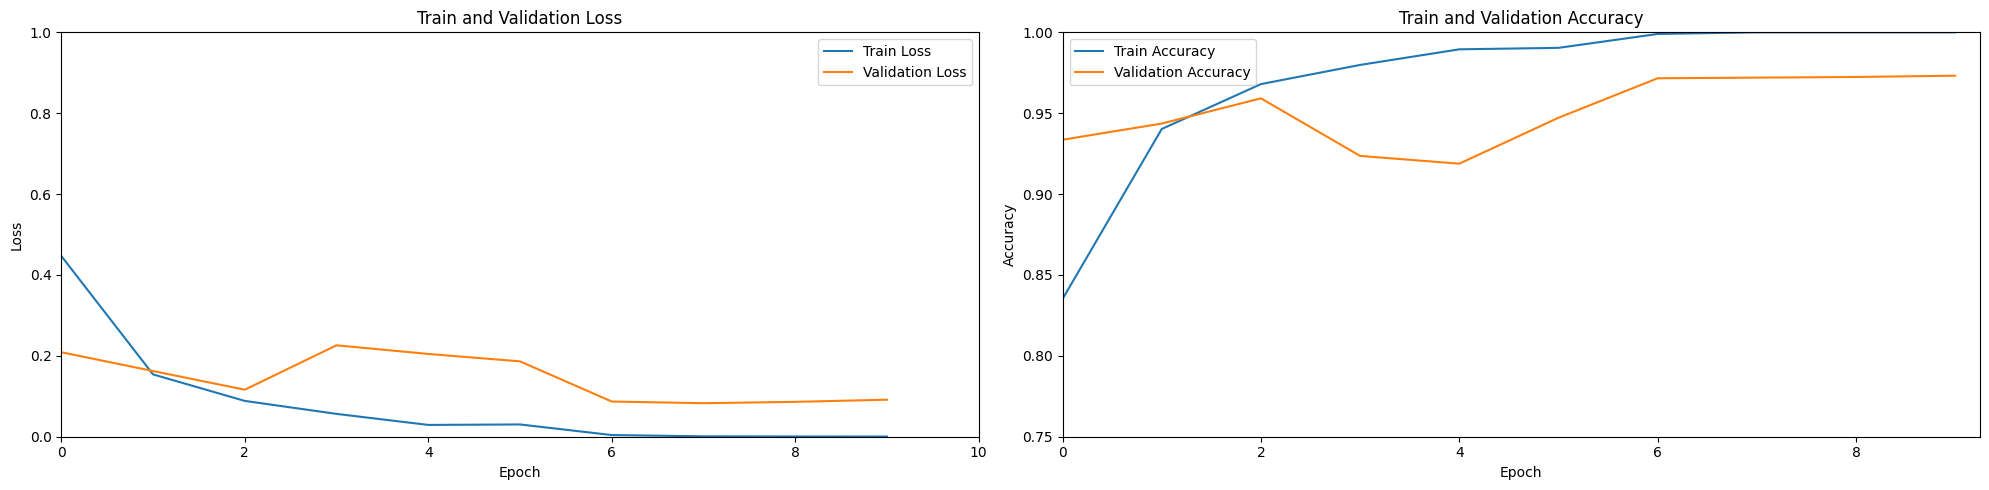

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [ ]:
Y_pred = model_1.predict(test_gen)
predicted_classes = np.argmax(Y_pred, axis=1)
true_classes = test_gen.classes

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices.keys())
print(report)

79/79 [==============================] - 85s 1s/step
              precision    recall  f1-score   support

   colon_aca       0.99      1.00      0.99       479
     colon_n       1.00      0.99      1.00       519
    lung_aca       0.94      0.94      0.94       488
      lung_n       1.00      0.99      0.99       498
    lung_scc       0.94      0.96      0.95       516

    accuracy                           0.98      2500
   macro avg       0.98      0.98      0.98      2500
weighted avg       0.98      0.98      0.98      2500



Second Model

In [19]:
model_2 = keras.models.Sequential()

model_2.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model_2.add(keras.layers.Dropout(0.1))
model_2.add(keras.layers.MaxPooling2D())

model_2.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_2.add(keras.layers.Dropout(0.2))
model_2.add(keras.layers.MaxPooling2D())

model_2.add(keras.layers.Flatten())
model_2.add(keras.layers.Dense(128, activation='relu'))
model_2.add(keras.layers.Dense(5, activation='softmax'))

model_2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 dropout (Dropout)           (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 dropout_1 (Dropout)         (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                   

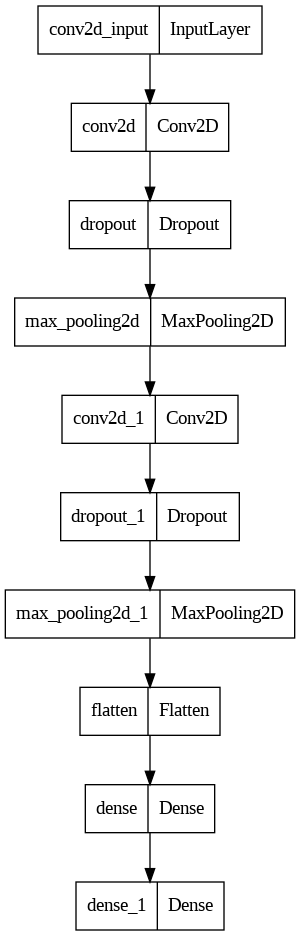

In [20]:
keras.utils.plot_model(
    model_2,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [22]:
history = model_2.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    callbacks=[early_stopping, plateau],
)


Epoch 1/5
625/625 [==============================] - 2454s 4s/step - loss: 0.0608 - accuracy: 0.9778 - val_loss: 0.2277 - val_accuracy: 0.9292 - lr: 0.0010
Epoch 2/5
625/625 [==============================] - 2449s 4s/step - loss: 0.0406 - accuracy: 0.9872 - val_loss: 0.2605 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 3/5
625/625 [==============================] - 2496s 4s/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.2664 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 4/5
625/625 [==============================] - ETA: 0s - loss: 0.0315 - accuracy: 0.9901
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
625/625 [==============================] - 2600s 4s/step - loss: 0.0315 - accuracy: 0.9901 - val_loss: 0.2454 - val_accuracy: 0.9340 - lr: 0.0010
Epoch 5/5
625/625 [==============================] - 2582s 4s/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.2389 - val_accuracy: 0.9400 - lr: 1.0000e-04


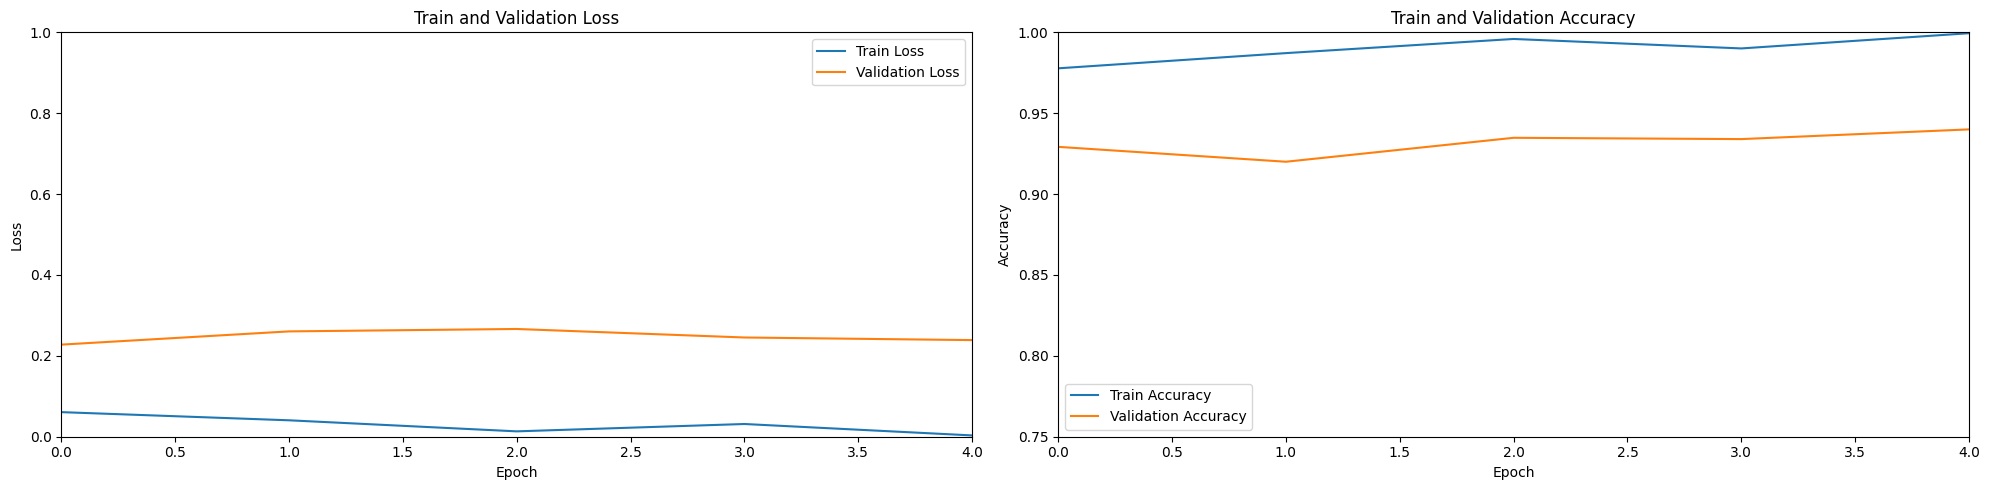

In [25]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 4)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 4)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [26]:
Y_pred = model_2.predict(test_gen)
predicted_classes = np.argmax(Y_pred, axis=1)
true_classes = test_gen.classes

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices.keys())
print(report)

79/79 [==============================] - 82s 1s/step
              precision    recall  f1-score   support

   colon_aca       0.96      0.92      0.94       516
     colon_n       0.93      0.97      0.94       498
    lung_aca       0.91      0.92      0.92       479
      lung_n       0.99      0.99      0.99       519
    lung_scc       0.94      0.93      0.93       488

    accuracy                           0.95      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.95      0.95      0.95      2500



Third Model

In [27]:
model_3 = keras.models.Sequential()

model_3.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model_3.add(keras.layers.MaxPooling2D())

model_3.add(keras.layers.Conv2D(64, 3, activation='relu'))
model_3.add(keras.layers.MaxPooling2D())

model_3.add(keras.layers.Flatten())
model_3.add(keras.layers.Dense(128, activation='relu'))
model_3.add(keras.layers.Dense(5, activation='softmax'))

model_3.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_2 (Dense)             (None, 128)              

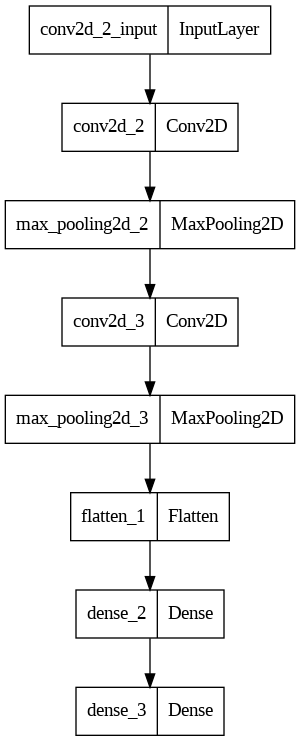

In [28]:
keras.utils.plot_model(
    model_3,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [31]:
history = model_3.fit(train_gen,
    validation_data=valid_gen,
          epochs = 5,
          callbacks=[early_stopping,plateau],)

Epoch 1/5
625/625 [==============================] - 1881s 3s/step - loss: 0.0542 - accuracy: 0.9807 - val_loss: 0.5307 - val_accuracy: 0.8560 - lr: 0.0010
Epoch 2/5
625/625 [==============================] - 1876s 3s/step - loss: 0.0364 - accuracy: 0.9886 - val_loss: 0.2016 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 3/5
625/625 [==============================] - 1872s 3s/step - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.2680 - val_accuracy: 0.9472 - lr: 0.0010
Epoch 4/5
625/625 [==============================] - 1871s 3s/step - loss: 0.0458 - accuracy: 0.9844 - val_loss: 0.2935 - val_accuracy: 0.9232 - lr: 0.0010
Epoch 5/5
625/625 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9941
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
625/625 [==============================] - 1897s 3s/step - loss: 0.0169 - accuracy: 0.9941 - val_loss: 0.2974 - val_accuracy: 0.9380 - lr: 0.0010


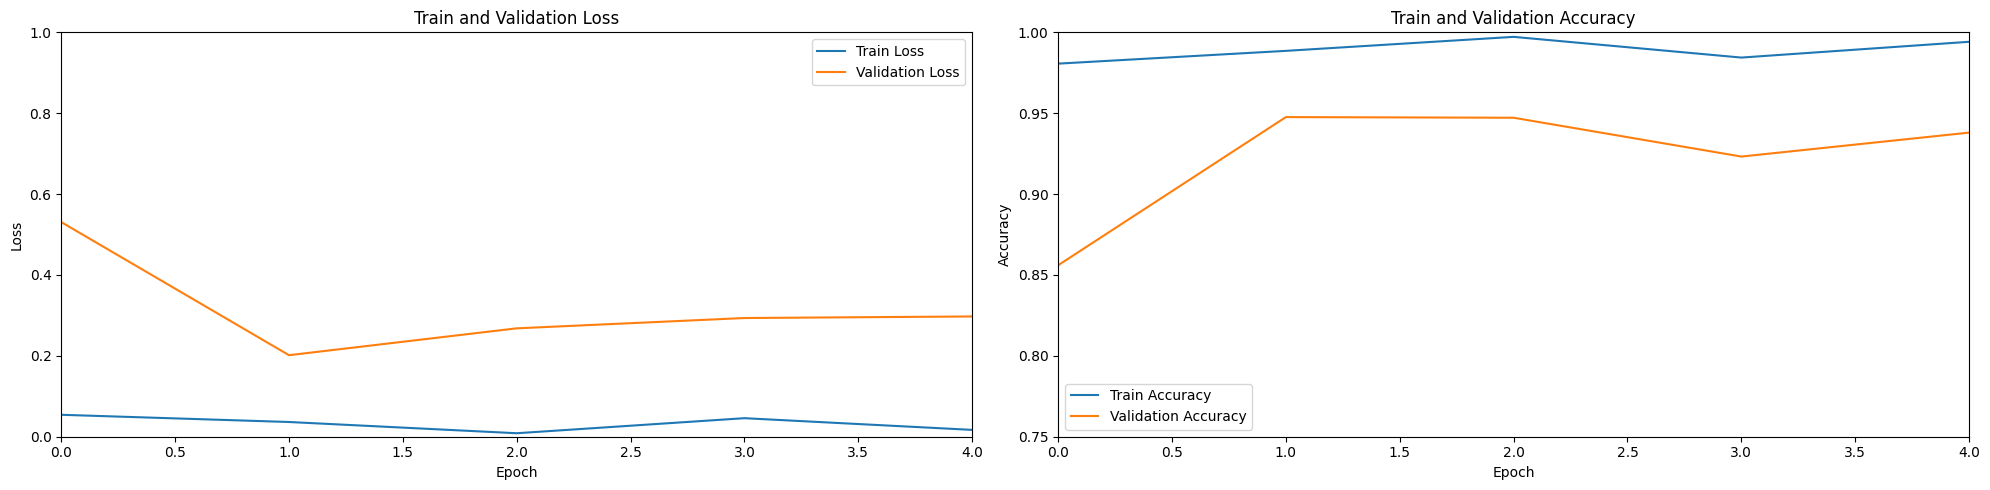

In [35]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 4)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 4)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [33]:
Y_pred = model_3.predict(test_gen)
predicted_classes = np.argmax(Y_pred, axis=1)
true_classes = test_gen.classes

# Print classification report
report = classification_report(true_classes, predicted_classes, target_names=test_gen.class_indices.keys())
print(report)

79/79 [==============================] - 87s 1s/step
              precision    recall  f1-score   support

   colon_aca       0.99      0.90      0.94       516
     colon_n       0.90      0.99      0.95       498
    lung_aca       0.90      0.94      0.92       479
      lung_n       1.00      0.99      0.99       519
    lung_scc       0.95      0.91      0.93       488

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500

